# PART 3

### TODO: part 3 loook at the definition of a  kernel, for the baseline you can use SVM with any kernel with pixels as inputs

### PREPARE THE DATA

In [28]:
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

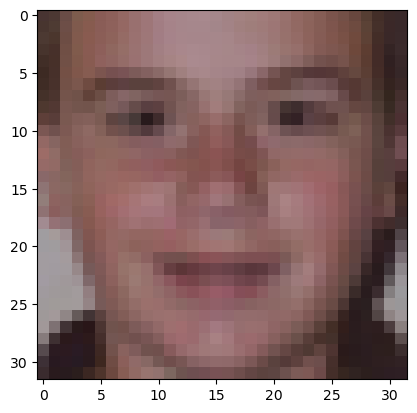

In [130]:
class Faces(Dataset):
    def __init__(self, root_dir="data"):
        self.root_dir = root_dir
        self.data = []
        for file in os.listdir(root_dir):
            if file.endswith(".jpg"):
                age = int(file.split("_")[0])
                self.data.append({"path": file, "age": age})

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        full_path = os.path.join(self.root_dir, sample["path"])
        image = Image.open(full_path).convert("RGB").resize((32, 32))
        image = np.array(image)
        age = sample["age"]
        return image, age


fcs = Faces()
plt.imshow(fcs.__getitem__(3)[0])

In [131]:
dataset = Faces()
# Convert dataset to data and labels
images = []
ages = []

for img, age in dataset:
    images.append(img)
    ages.append(age)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(images, ages, test_size=0.2, random_state=42)

### Linear kernel

In [132]:
# Reshape to features vectors
X_train_basic = [x.reshape(-1) for x in X_train]
X_test_basic = [x.reshape(-1) for x in X_test]

# Scale the data
scaler = StandardScaler()
scaler.fit(X_train_basic)
X_train_basic = scaler.transform(X_train_basic)
X_test_basic = scaler.transform(X_test_basic)

In [154]:
from hw_kernels import SVR, RBF, Polynomial, Linear, KernelizedRidgeRegression
from sklearn.metrics import mean_squared_error

fitter = KernelizedRidgeRegression(RBF(sigma=1000),lambda_=0.001)
model = fitter.fit(X_train_basic, y_train)
preds = model.predict(X_test_basic)
mean_squared_error(y_test, preds)

209.5258595683602

### Custom kernel

In [134]:
def normalize_images(X):
    normed = []
    for img in X:
        img = img.astype(np.float32)
        img = img/255
        normed.append(img)
    return normed

In [135]:
from sklearn.feature_extraction.image import extract_patches_2d
from tqdm import tqdm

class ConvolutionalKernel:
    def __init__(self, patch_size = 3, kernel = Linear()):
        self.patch_size = patch_size
        self.kernel = kernel

    def extract_and_flatten_patches(self, img):
        patches = extract_patches_2d(img, (self.patch_size, self.patch_size))
        return patches.reshape(patches.shape[0], -1)

    def __call__(self, A, B):
        patches_A = [self.extract_and_flatten_patches(img) for img in A]
        patches_B = [self.extract_and_flatten_patches(img) for img in B]

        K = np.zeros((len(A), len(B)))
        for i, pa in tqdm(enumerate(patches_A)):
            for j, pb in enumerate(patches_B):
                K_patches = self.kernel(pa, pb)

                K[i, j] = np.mean(K_patches)

        return K
                
  

## Test new kernel with linear as base

In [158]:
X_train_convolutional = normalize_images(X_train)
X_test_convolutional = normalize_images(X_test)

fitter = KernelizedRidgeRegression(ConvolutionalKernel(kernel=RBF(sigma=1000),patch_size=5),lambda_=0.001)
#fitter = KernelizedRidgeRegression(ConvolutionalKernel(patch_size=5),lambda_=0.001)
model = fitter.fit(X_train_convolutional, y_train)

798it [1:26:31,  6.51s/it]


In [ ]:
preds = model.predict(X_test_convolutional)
mean_squared_error(y_test, preds)

25it [03:20,  6.65s/it]

## Test new kernel with RBF as base

In [ ]:
X_train_convolutional = normalize_images(X_train)
X_test_convolutional = normalize_images(X_test)

fitter = KernelizedRidgeRegression(ConvolutionalKernel(kernel=RBF(sigma=1000)),lambda_=0.001)
model = fitter.fit(X_train_convolutional, y_train)

In [ ]:
preds = model.predict(X_test_convolutional)
mean_squared_error(y_test, preds)